# MTH8408 PROJET DE LABORATOIRE 2 

$\color{orange}{\text{NOM : }}$ DOFFONSOU $\newline$
$\color{orange}{\text{PRÉNOMS : }}$ PIERRE-RICHARD JUNIOR   $\newline$
$\color{orange}{\text{MATRICULE : }}$ 2002871      


### Exercice 1  - Méthode quasi-Newton BFGS quadratique convexe

In [ ]:
import Pkg; Pkg.add("NLPModels")

In [2]:
using JuMP
using Ipopt
using MathOptInterface
using ADNLPModels, LinearAlgebra, NLPModels, Printf

In [ ]:
#Amélioration possibles: return also the value of f
function alpha(dk,gk,A)
    α = -(transpose(gk)*dk)/(transpose(dk)*A*dk)
    return α
end
function armijo_modifie(xk, dk, fk, gk, f,A)
    slope = dot(gk, dk) #doit être <0
    t = 1.0
    while f(xk + t * dk) > fk + alpha(dk,gk,A) * t * slope
      t /= 1.5
    end
    return t
  end


function bfgs_quasi_newton_armijo(nlp, x0,A,b; verbose::Bool = true)
    xk = x0
    fk  = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)  # gnorm0 = norm(gk)
    k = 0
    t=0
    verbose && @printf "%2s %9s %9s %7s\n" "k" "fk" "||∇f(x)||" "t"
    verbose && @printf "%2d %9.2e %9.1e %7.1e\n" k fk gnorm t

    # première itération
    H0 = I(length(xk))
    d0 = - H0*gk
    t = armijo_modifie(xk,d0,fk,gk,f,A)
    xk_1 = xk + t * d0
    fk = obj(nlp, xk_1)
    gk = grad(nlp, xk_1)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t

    yk = grad(nlp,xk_1) - grad(nlp,xk)
    sk = xk_1 - xk 
    ρk = 1/(transpose(yk)*sk)
    Hk = (transpose(yk)*sk)/(transpose(yk)*yk)*I(length(xk_1))
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
        if transpose(yk)*sk > 0 
        Hk_1 = (I(length(xk_1)) - ρk*sk*transpose(yk))* Hk * (I(length(xk_1)) - ρk*yk*transpose(sk)) + ρk*sk*transpose(sk)
        else 
        Hk_1 = Hk
        end
        dk = - Hk_1 *grad(nlp,xk_1)
        xk = xk_1
        fk = obj(nlp,xk_1)
        gk = grad(nlp, xk_1)
        t = armijo_modifie(xk,dk,fk,gk,f,A)
        xk_1 += t * dk 
        gnorm = norm(gk)
        k += 1
        verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
        yk = grad(nlp,xk_1) - grad(nlp,xk)
        sk = xk_1 - xk 
        ρk = 1/(transpose(yk)*sk)
    end
    return xk
end

In [ ]:
# Test 
n = 10
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1))
b = A * [1:n;]

f(x) = 0.5*transpose(x)*A*x - transpose(b)*x
nlp = ADNLPModel(f, zeros(n))
x0 = zeros(n)
x_final = bfgs_quasi_newton_armijo(nlp, x0,A,b)


$A$ est une matrice symétrique et définie positive et $d$ est un vecteur à $n$ lignes et 1 colonne. Par définition, si $A$ est symétrique et définie positive et $d$ est est vecteur non nul, alors $d^TAd > 0$. Cela permet de conclure que $\alpha$ est toujours bien défini théoriquement. 

### Exercice 2 Étude de convergence 


In [11]:
function alpha(dk,gk,A)
    α = -(transpose(gk)*dk)/(transpose(dk)*A*dk)
    return α
end

function armijo(xk, dk, fk, gk, f)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

function armijo_modifie(xk, dk, fk, gk, f,A)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + alpha(dk,gk,A) * t * slope
    t /= 1.5
  end
  return t
end


function newton_ldlt_armijo(nlp, x0; verbose::Bool = true)
  k_vector = zeros(0)
  xk  = x0
  xk_vector = transpose(xk)
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  k_vector = append!(k_vector,k)
  verbose && @printf "%3s %9s %9s\n" "k" "fk" "||∇f(x)||"
  # verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    Sk = ldl_analyze(Hk)
    ldl_factorize!(Hk, Sk)
    if !all(Sk.d .>= 0) 
      Sk.d .+= -minimum(Sk.d) + 1e-6
    end
    dk = - Sk \ gk
    slope = dot(dk, gk)
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    xk_vector = vcat(xk_vector,transpose(xk))
    k_vector = append!(k_vector,k)
    # verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  verbose && @printf "%3d %9.2e %9.1e \n" k fk gnorm
  return xk,xk_vector,k_vector
end


# exo 3 du lab 
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)
  k_vector = zeros(0)
  xk = x0
  xk_vector = transpose(xk)
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)  # gnorm0 = norm(gk)
  k = 0
  k_vector = append!(k_vector,k)
  t=0
  verbose && @printf "%2s %9s %9s %7s\n" "k" "fk" "||∇f(x)||" "t"
  # verbose && @printf "%2d %9.2e %9.1e %7.1e\n" k fk gnorm t

  # première itération
  H0 = I(length(xk))
  d0 = - H0*gk
  t = armijo(xk, d0, fk, gk, x -> obj(nlp, x))
  xk_1 = xk + t * d0
  fk = obj(nlp, xk_1)
  gk = grad(nlp, xk_1)
  gnorm = norm(gk)
  k += 1
  xk_vector = vcat(xk_vector,transpose(xk_1))
  k_vector = append!(k_vector,k)
  # verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t

  yk = grad(nlp,xk_1) - grad(nlp,xk)
  sk = xk_1 - xk 
  ρk = 1/(transpose(yk)*sk)
  Hk = (transpose(yk)*sk)/(transpose(yk)*yk)*I(length(xk_1))
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    if transpose(yk)*sk > 0 
      Hk_1 = (I(length(xk_1)) - ρk*sk*transpose(yk))* Hk * (I(length(xk_1)) - ρk*yk*transpose(sk)) + ρk*sk*transpose(sk)
    else 
      Hk_1 = Hk
    end
    dk = - Hk_1 *grad(nlp,xk_1)
    xk = xk_1
    fk = obj(nlp,xk_1)
    gk = grad(nlp, xk_1)
    t = armijo(xk_1, dk, fk, gk, x -> obj(nlp, x))
    xk_1 += t * dk 
    gnorm = norm(gk)
    k += 1
    xk_vector = vcat(xk_vector,transpose(xk_1))
    k_vector = append!(k_vector,k)
    # verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    yk = grad(nlp,xk_1) - grad(nlp,xk)
    sk = xk_1 - xk 
    ρk = 1/(transpose(yk)*sk)
  end
  verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  return xk,xk_vector,k_vector
end

function  distance_vector(xk_vector,x_final)
  dist = zeros(0)
  for i in 1:size(xk_vector)[1] 
      dist = append!(dist,sqrt(sum((xk_vector[i,:] - x_final).^2)))
  end
  return dist 
end

function convergence_lineaire(xk_vector,xk)
  convergence_lin = zeros(0)
  for i in 1:size(xk_vector)[1]-1 
      convergence_lin = append!(convergence_lin,sqrt(sum((xk_vector[i+1,:] - xk).^2))/sqrt(sum((xk_vector[i,:] - xk).^2)))
  end
  return convergence_lin 
end

function convergence_quadratique(xk_vector,xk)
  convergence_quad = zeros(0)
  for i in 1:size(xk_vector)[1]-1 
      convergence_quad = append!(convergence_quad,sqrt(sum((xk_vector[i+1,:] - xk).^2))/sqrt(sum((xk_vector[i,:] - xk).^2))^2)
  end
  return convergence_quad
end

convergence_quadratique (generic function with 1 method)

In [ ]:
import Pkg; Pkg.add("LaTeXStrings")
import Pkg; Pkg.add("LDLFactorizations")

 k        fk ||∇f(x)||       t
22  4.06e-13   4.8e-06 6.7e-01 


  k        fk ||∇f(x)||
  6  9.79e-16   4.4e-07 


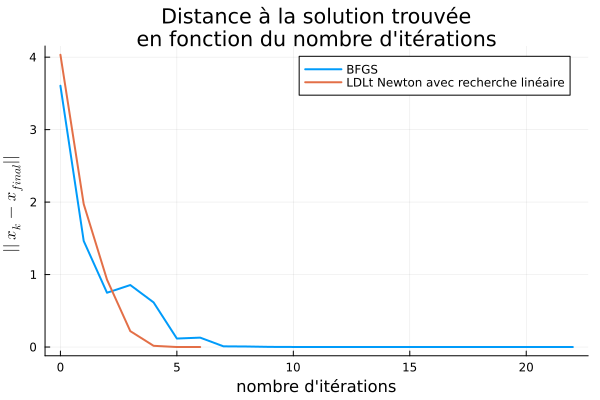

In [12]:
using Plots
using LaTeXStrings
using LDLFactorizations, LinearAlgebra

fH(x) = (x[2] + x[1]^2-11)^2 + (x[1]+x[2]^2-7)^2

nlp = ADNLPModel(fH, zeros(2))
x0 = zeros(2)
xk, xk_vector, k_vector = bfgs_quasi_newton_armijo(nlp, x0)
xk1, xk1_vector, k1_vector = newton_ldlt_armijo(nlp,x0)


# Distance à la solution trouvée
distance_BFGS = distance_vector(xk_vector,xk)
distance_LDLT = distance_vector(xk1_vector,xk1)

plot(k_vector,distance_BFGS,lw=2,label="BFGS",grid=true)
plot!(k1_vector,distance_LDLT,lw=2,label="LDLt Newton avec recherche linéaire")
title!("Distance à la solution trouvée\nen fonction du nombre d'itérations")
xlabel!("nombre d'itérations")
ylabel!(L"$\vert \vert x_k - x_{final} \vert \vert$")


La méthode LDLt Newton avec recherche linéaire converge en moins d'itération comparée à la méthode BFGS. Ce résultat était prévisible car la méthode LDLt est d'ordre 2 tandis que la méthode BFGS n'est que d'ordre 1. 

|       | Nombre d'itérations |
|-------|:-------------------:|
|  BFGS |          22         |
| LDLt  |          6          |

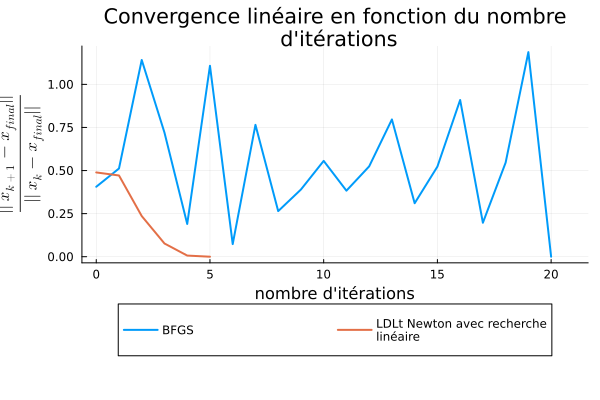

In [249]:
# Convergence linéaire
convergence_lin_BFGS = convergence_lineaire(xk_vector,xk)
convergence_lin_LDLT = convergence_lineaire(xk1_vector,xk1)

plot(k_vector[1:length(k_vector)-1],convergence_lin,lw=2,label="BFGS",grid=true)
plot!(k1_vector[1:length(k1_vector)-1],convergence_lin_LDLT,lw=2,label="LDLt Newton avec recherche\nlinéaire",grid=true)
plot!(legend=:outerbottom, legendcolumns=2)
title!("Convergence linéaire en fonction du nombre\n d'itérations")
xlabel!("nombre d'itérations")
ylabel!(L"\frac{\vert \vert x_{k+1} - x_{final}\vert \vert}{\vert \vert x_k - x_{final}\vert \vert}")


|       |     Comportement de la convergence linéaire     |
|-------|:-----------------------------------------------:|
|  BFGS | Oscillant, descente vers 0  après 22 itérations |
| LDLt  |         Décroissance jusqu'à atteindre 0        |

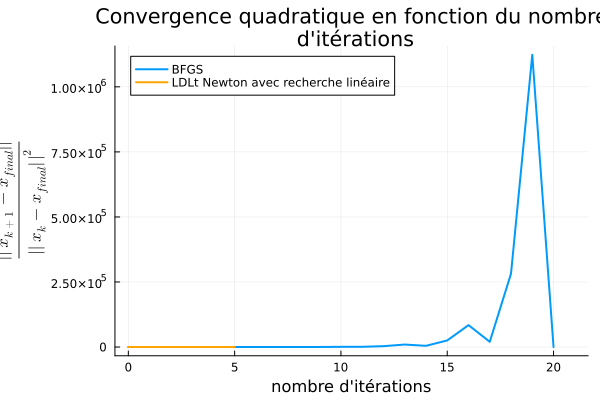

In [250]:
# Convergence quadratique
convergence_quad_BFGS = convergence_quadratique(xk_vector,xk)
convergence_quad_LDLT = convergence_quadratique(xk1_vector,xk1)
plot(k_vector[1:length(k_vector)-1],convergence_quad_BFGS,lw=2,label="BFGS",grid=true)
plot!(k1_vector[1:length(k1_vector)-1],convergence_quad_LDLT,lw=2,label="LDLt Newton avec recherche linéaire",color=:orange)
title!("Convergence quadratique en fonction du nombre\n d'itérations")
xlabel!("nombre d'itérations")
ylabel!(L"\frac{\vert \vert x_{k+1} - x_{final}\vert \vert}{\vert \vert x_k - x_{final}\vert \vert^2}")

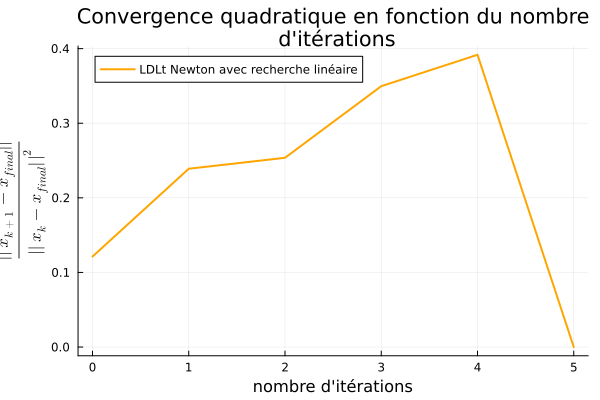

In [251]:
plot(k1_vector[1:length(k1_vector)-1],convergence_quad_LDLT,lw=2,label="LDLt Newton avec recherche linéaire",color=:orange)
title!("Convergence quadratique en fonction du nombre\n d'itérations")
xlabel!("nombre d'itérations")
ylabel!(L"\frac{\vert \vert x_{k+1} - x_{final}\vert \vert}{\vert \vert x_k - x_{final}\vert \vert^2}")

### Exercice 3 Problème 203

#### Modèle JuMP

In [241]:
model = Model(Ipopt.Optimizer)
@variable(model,x1,start=2)
@variable(model,x2,start=0.2)
@NLobjective(model, Min,(1.5-x1*(1-x2))^2+(2.25-x1*(1-x2^2))^2+(2.625-x1*(1-x2^3))^2)
JuMP.optimize!(model)
@show JuMP.has_values(model)
@show JuMP.termination_status(model) == MathOptInterface.LOCALLY_SOLVED
@show JuMP.primal_status(model) == MathOptInterface.FEASIBLE_POINT
@show JuMP.dual_status(model) == MathOptInterface.FEASIBLE_POINT
@show JuMP.value(x1)
@show JuMP.value(x2)              
@show JuMP.objective_value(model)   

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.2978100e-01 0.00e+00 1.75e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

1.3708824810930743e-26

#### Modèle ADNPLModel 

In [247]:
x0 = [2,0.2]
c = [1.5,2.25,2.625]
f(x) = (c[1] - x[1]*(1-x[2]))^2 + (c[2] - x[1]*(1-x[2]^2))^2 + (c[3] - x[1]*(1-x[2]^3))^2
nlp = ADNLPModel(f, x0)
xk,xk_vector,k_vector = newton_ldlt_armijo(nlp, x0)
println("x1 = ",xk[1])
println("x2 = ",xk[2])

  k        fk ||∇f(x)||
  6  2.08e-14   6.4e-07 
x1 = 2.9999996739422152
x2 = 0.49999993195057274
